# Installation and dependencies

In [1]:
%pip install tensorflow==2.14.1 opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil
import time

In [3]:
# Tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# Creating data directories

In [4]:
# Setting up dirs
POS_DIR = os.path.join("data", "positive")
NEG_DIR = os.path.join("data", "negative")
ANC_DIR = os.path.join("data", "anchor")

# Checking if the folders exist
POS_DIR_isExist = os.path.exists(POS_DIR)
NEG_DIR_isExist = os.path.exists(NEG_DIR)
ANC_DIR_isExist = os.path.exists(POS_DIR)

# Creating dirs
os.makedirs(POS_DIR) if not POS_DIR_isExist else None
os.makedirs(NEG_DIR) if not NEG_DIR_isExist else None
os.makedirs(ANC_DIR) if not ANC_DIR_isExist else None

# Data collection

## Collecting positive examples

In [5]:
'''
    Dataset:
    https://www.kaggle.com/datasets/jessicali9530/lfw-dataset?resource=download
'''

# Unzipping kaggle data
with ZipFile("archive.zip", "r") as zip_object:
    zip_object.extractall()

# Replace old paths with new paths
lfw = "lfw-deepfunneled/lfw-deepfunneled/"

# Move the images to negative example
for dir in os.listdir(lfw):
    for file in os.listdir(os.path.join(lfw, dir)):
        OLD_PATH = os.path.join(lfw, dir, file)
        NEW_PATH = os.path.join(NEG_DIR, file)
        os.replace(OLD_PATH, NEW_PATH)

# Remove now empty directory
shutil.rmtree("lfw-deepfunneled")

# Set up webcam for postive and anchor collection

In [37]:
# Function for cutting the frame to match image data
def center_crop(img, dim):
    width, height  = img.shape[1], img.shape[0]

    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0]

    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 

    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2, :]

    return crop_img

In [42]:
# Import uuid library
import uuid
uuid.uuid1()

UUID('2de513ee-c0f8-11ee-949d-9a60f45df4af')

In [46]:
# Constructing camera object
deviceID = 0 # 0-webcam, 1-laptop
cap = cv2.VideoCapture(deviceID)

# Error handling when opening the camera is not available
if not cap.isOpened():
    exit()

while cap.isOpened():
    # Capture return value and frame
    ret, frame = cap.read()

    # Error handling if no return value
    if not ret:
        break

    # Reduced the frame
    size = (250, 250)
    frame = center_crop(frame, size)

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord("a"):
        imgname = os.path.join(ANC_DIR, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord("p"):
        imgname = os.path.join(POS_DIR, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Show the frame
    cv2.imshow("Webcam frame", frame)
    # Creating quit key
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the capture and destroy frames
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

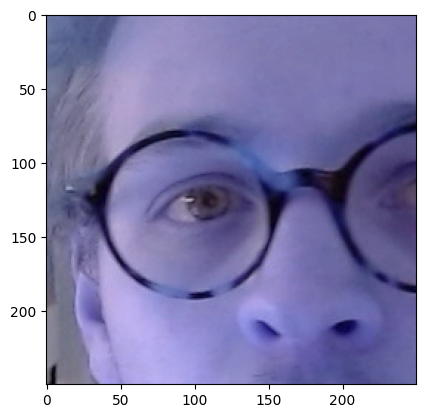

In [47]:
plt.imshow(frame)